In [1]:
# Import necessary libraries for data manipulation, analysis, and modeling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns  
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.exceptions import NotFittedError
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

## Define the SP500DataHandler Class

In [12]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define a class to encapsulate operations related to handling S&P 500 market data
class SP500DataHandler:
    # Define class-level attributes for consistent column naming across methods
    DATE_COLUMN = 'Date'
    OPEN_COLUMN = 'Open'
    HIGH_COLUMN = 'High'
    LOW_COLUMN = 'Low'
    VOLUME_COLUMN = 'Volume'
    ADJ_CLOSE_COLUMN = 'Adj Close'
    # Additional attributes for engineered features
    VOLUME_10DAY_AVG = 'Volume_10day_avg'
    ADJ_CLOSE_10DAY_AVG = 'Adj_Close_10day_avg'
    PREDICTIONS_COLUMN = 'predictions'
    CLOSE_LAST_COLUMN = 'Close/Last'
    EMA_12_COLUMN = 'EMA_12'
    EMA_26_COLUMN = 'EMA_26'
    MAC_D_LINE_COLUMN = 'MACD'
    SIGNAL_LINE_COLUMN = 'Signal_Line'
    MACD_HISTORGRAM_COLUMN = 'MACD_Histogram'
    # Date component attributes for temporal analysis
    YEAR_COLUMN = 'Year'
    MONTH_COLUMN = 'Month'
    DAY_COLUMN = 'Day'
    DAY_OF_WEEK_COLUMN = 'DayOfWeek'
    # Financial metrics for analysis
    DAILY_RETURNS_COLUMN = 'Daily Returns'
    VOLATILITY_COLUMN = 'Volatility'
    RESIDUALS_COLUMN = 'residuals'
    # Moving average attributes for trend analysis
    MA50_ADJ_COLUMN = 'MA50_Adj'
    MA200_ADJ_COLUMN = 'MA200_Adj'
    VWAP_COLUMN = 'VWAP'

    def __init__(self, file_path):
        # Initialize with the path to market data file
        self.file_path = file_path  # Store the provided file path
        self.data = None  # Initialize data attribute as None to be populated by load_data method
        # Initialize models dictionary with regression models for experimentation
        self.models = {
            'LinearRegression': LinearRegression(),
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'RandomForest': RandomForestRegressor(),
            'GradientBoosting': GradientBoostingRegressor()
        }
        # Define parameter grids for model tuning via GridSearchCV
        self.param_grid = {
            'Ridge': {'alpha': [10, 50, 100, 200]},
            'Lasso': {'alpha': [0.01, 0.1, 1, 10, 100], 'max_iter': [5000]},
            'RandomForest': {'n_estimators': [100, 200, 300], 'max_depth': [10, 20, 30, None]},
            'GradientBoosting': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]}
        }

    def load_data(self, start_date=None, end_date=None):
        # Load S&P 500 market data from the specified file path
        try:
            # Load data, parsing dates in the specified DATE_COLUMN
            self.data = pd.read_csv(self.file_path, parse_dates=[self.DATE_COLUMN])
            print("Data loaded successfully.")
            # If start and end dates are provided, filter the data accordingly
            if start_date and end_date:
                self.data = self.data[(self.data[self.DATE_COLUMN] >= pd.to_datetime(start_date)) &
                                      (self.data[self.DATE_COLUMN] <= pd.to_datetime(end_date))]
        except FileNotFoundError:
            # Handle the case where the specified file does not exist
            print(f"File not found: {self.file_path}")
        except Exception as e:
            # Catch all other exceptions, printing an error message with details
            print(f"Failed to load data: {e}")

    def clean_data(self):
        # Clean and preprocess loaded data
        if self.data is not None:
            # Drop rows with missing values to ensure data quality
            self.data.dropna(inplace=True)
            # Extract date components from DATE_COLUMN for temporal analysis
            self.data[self.YEAR_COLUMN] = self.data[self.DATE_COLUMN].dt.year
            self.data[self.MONTH_COLUMN] = self.data[self.DATE_COLUMN].dt.month
            self.data[self.DAY_COLUMN] = self.data[self.DATE_COLUMN].dt.day
            self.data[self.DAY_OF_WEEK_COLUMN] = self.data[self.DATE_COLUMN].dt.dayofweek
            print("Data cleaning and feature engineering completed.")
        else:
            # Notify if data is not loaded before attempting to clean
            print("Data not loaded. Please load the data first.")

    def ten_day_avg(self):
        # Compute 10-day rolling averages for volume and adjusted close price
        if self.VOLUME_COLUMN in self.data.columns and self.ADJ_CLOSE_COLUMN in self.data.columns:
            self.data[self.VOLUME_10DAY_AVG] = self.data[self.VOLUME_COLUMN].rolling(window=10).mean()
            self.data[self.ADJ_CLOSE_10DAY_AVG] = self.data[self.ADJ_CLOSE_COLUMN].rolling(window=10).mean()
            # Replace infinite values with NaN and then fill them with column mean
            self.data.replace([np.inf, -np.inf], np.nan, inplace=True)
            self.data.fillna(self.data.mean(numeric_only=True), inplace=True)
            print("Feature engineering completed: 10-day averages added.")
        else:
            print("Required columns for feature engineering are missing.")

    def calculate_daily_returns_and_volatility(self):
        # Calculate daily returns and volatility for risk assessment
        self.data[self.DAILY_RETURNS_COLUMN] = self.data[self.CLOSE_LAST_COLUMN].pct_change()
        self.data[self.VOLATILITY_COLUMN] = self.data[self.DAILY_RETURNS_COLUMN].rolling(window=30).std() * np.sqrt(30)

    def feature_engineering(self):
        # Perform additional feature engineering to enhance the dataset
        if self.data is not None:
            # Calculate moving averages for 'Adj Close' to smooth out price data
            self.data[self.MA50_ADJ_COLUMN] = self.data[self.ADJ_CLOSE_COLUMN].rolling(window=50).mean()
            self.data[self.MA200_ADJ_COLUMN] = self.data[self.ADJ_CLOSE_COLUMN].rolling(window=200).mean()
            # Calculate Volume-Weighted Average Price (VWAP) as an additional feature
            cum_vol_price = (self.data[self.VOLUME_COLUMN] * self.data[self.ADJ_CLOSE_COLUMN]).cumsum()
            cum_volume = self.data[self.VOLUME_COLUMN].cumsum()
            self.data[self.VWAP_COLUMN] = cum_vol_price / cum_volume
            
            # Calculate the MACD
            # Calculate the 12-period EMA of the adjusted closing price
            self.data['EMA_12'] = self.data[self.ADJ_CLOSE_COLUMN].ewm(span=12, adjust=False).mean()

            # Calculate the 26-period EMA of the adjusted closing price
            self.data['EMA_26'] = self.data[self.ADJ_CLOSE_COLUMN].ewm(span=26, adjust=False).mean()

            # Calculate the MACD line by subtracting the 26-period EMA from the 12-period EMA
            self.data['MACD'] = self.data['EMA_12'] - self.data['EMA_26']

            # Calculate the signal line, which is a 9-period EMA of the MACD line
            self.data['Signal_Line'] = self.data['MACD'].ewm(span=9, adjust=False).mean()

            # Calculate the MACD Histogram
            self.data['MACD_Histogram'] = self.data['MACD'] - self.data['Signal_Line']
            
            print("Feature engineering completed successfully.")
        else:
            print("Data not loaded. Please load and clean the data before feature engineering.")

    def split_data(self):
        # Split the dataset into training and testing sets
        X = self.data[[self.OPEN_COLUMN, self.HIGH_COLUMN, self.LOW_COLUMN, self.VOLUME_10DAY_AVG, self.ADJ_CLOSE_10DAY_AVG]]
        y = self.data[self.ADJ_CLOSE_COLUMN]
        # Perform the split with a test size of 30% and a fixed random state for reproducibility
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    def select_and_tune_model(self, cv=5):
        # Select and tune the best model from the initialized models
        scaler = StandardScaler()  # Initialize a scaler for feature normalization
        best_score = float('inf')  # Initialize best score to track the best model performance
        best_model_name = None  # Variable to store the name of the best model
        best_model = None  # Variable to store the best model instance

        for name, model in self.models.items():
            print(f"Processing {name}...")
            # Create a pipeline with scaling and the model
            pipeline = Pipeline([('scaler', scaler), ('model', model)])
            if name in self.param_grid:
                # If a parameter grid is defined for the model, perform grid search
                adjusted_param_grid = {'model__' + key: value for key, value in self.param_grid[name].items()}
                grid_search = GridSearchCV(pipeline, adjusted_param_grid, cv=cv, scoring='neg_mean_squared_error')
                grid_search.fit(self.X_train, self.y_train)
                print(f"Best parameters for {name}: {grid_search.best_params_}")
                print(f"Best cross-validation score (MSE) for {name}: {-grid_search.best_score_}")
                # Update best model if this model performs better
                if -grid_search.best_score_ < best_score:
                    best_score = -grid_search.best_score_
                    best_model_name = name
                    best_model = grid_search.best_estimator_
            else:
                # For models without a parameter grid, fit the default model and perform cross-validation
                scores = cross_val_score(pipeline, self.X_train, self.y_train, cv=cv, scoring='neg_mean_squared_error')
                avg_score = -scores.mean()
                print(f"Average cross-validation score (MSE) for {name}: {avg_score}")
                # Update best model if this model performs better
                if avg_score < best_score:
                    best_score = avg_score
                    best_model_name = name
                    best_model = pipeline
                    best_model.fit(self.X_train, self.y_train)

        # Store the best model details
        self.best_model_name = best_model_name
        self.best_model = best_model
        self.best_score = best_score

        print(f"Best model: {self.best_model_name} with MSE: {self.best_score}")
        # Make predictions with the best model on the test set
        self.predictions = self.best_model.predict(self.X_test)

        # Initialize a column for predictions in the dataset and fill it for the test set
        self.data[self.PREDICTIONS_COLUMN] = np.nan
        self.data.loc[self.X_test.index, self.PREDICTIONS_COLUMN] = self.predictions

        # Evaluate the best model using common regression metrics
        self.mse = mean_squared_error(self.y_test, self.predictions)
        self.mae = mean_absolute_error(self.y_test, self.predictions)
        self.r2 = r2_score(self.y_test, self.predictions)

        print(f"Evaluation Metrics for {self.best_model_name}: MSE={self.mse}, MAE={self.mae}, R2={self.r2}")

    def perform_cross_validation(self, cv=5):
        # Perform cross-validation to assess the model's performance
        try:
            # Ensure the model has been fitted
            if not hasattr(self.best_model, 'fit'):
                raise ValueError("Model must be fitted before performing cross-validation.")

            cv_scores = cross_val_score(self.best_model, self.X_train, self.y_train, cv=cv, scoring='neg_mean_squared_error')
            self.cv_mse_scores = -cv_scores  # Convert scores to positive values
            self.avg_cv_mse = np.mean(self.cv_mse_scores)  # Calculate average MSE
            self.cv_mse_scores_abs = np.abs(self.cv_mse_scores)  # Corrected this line
            print(f"Cross-validation performed with {cv} folds. Average MSE: {self.avg_cv_mse:.2f}")
        except ValueError as ve:
            print(f"Value Error: {ve}")
        except Exception as e:
            print(f"Unexpected error during cross-validation: {e}")


    def visualize_predictions(self):
        # Visualize the actual vs. predicted values
        plt.figure(figsize=(10, 6))
        plt.scatter(self.y_test, self.predictions, alpha=0.5)
        plt.plot([self.y_test.min(), self.y_test.max()], [self.y_test.min(), self.y_test.max()], 'k--', lw=2)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('Actual vs. Predicted Values')
        plt.show()

    def feature_importance(self):
        # Visualize the importance of features used in the linear regression model
        if hasattr(self.best_model, 'coef_'):
            importance = self.best_model.coef_
            features = [self.OPEN_COLUMN, self.HIGH_COLUMN, self.LOW_COLUMN, self.VOLUME_10DAY_AVG, self.ADJ_CLOSE_10DAY_AVG]
            plt.figure(figsize=(10, 6))
            plt.bar(features, importance)
            plt.xlabel('Feature')
            plt.ylabel('Coefficient Value')
            plt.title('Feature Importance')
            plt.xticks(rotation=45)
            plt.show()
        else:
            print("The selected model does not support feature importance.")

    def calculate_and_store_residuals(self):
        # Calculate and store residuals between actual closing prices and predictions
        if self.PREDICTIONS_COLUMN in self.data.columns and self.CLOSE_LAST_COLUMN in self.data.columns:
            self.data[self.RESIDUALS_COLUMN] = self.data[self.CLOSE_LAST_COLUMN] - self.data[self.PREDICTIONS_COLUMN]
            print("Residuals calculated and stored.")
        else:
            missing_columns = [col for col in [self.PREDICTIONS_COLUMN, self.CLOSE_LAST_COLUMN] if col not in self.data.columns]
            print(f"Required columns {missing_columns} are missing in the DataFrame.")

    def get_clean_data(self):
        # Return the cleaned and preprocessed data
        if self.data is not None:
            return self.data
        else:
            print("Data is not ready. Please ensure data is loaded, cleaned, and preprocessed.")
            return None


## Main Function

Data loaded successfully.
Data cleaning and feature engineering completed.
Feature engineering completed: 10-day averages added.
Feature engineering completed successfully.
Processing LinearRegression...
Average cross-validation score (MSE) for LinearRegression: 9.713288343038451
Processing Ridge...
Best parameters for Ridge: {'model__alpha': 10}
Best cross-validation score (MSE) for Ridge: 39.92030526290567
Processing Lasso...
Best parameters for Lasso: {'model__alpha': 0.01, 'model__max_iter': 5000}
Best cross-validation score (MSE) for Lasso: 13.600435744037132
Processing RandomForest...
Best parameters for RandomForest: {'model__max_depth': 30, 'model__n_estimators': 300}
Best cross-validation score (MSE) for RandomForest: 26.880873799787214
Processing GradientBoosting...
Best parameters for GradientBoosting: {'model__learning_rate': 0.1, 'model__n_estimators': 200}
Best cross-validation score (MSE) for GradientBoosting: 31.22830126721767
Best model: LinearRegression with MSE: 9.71

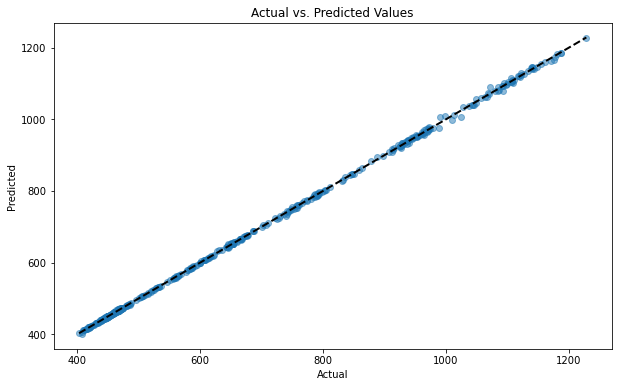

The selected model does not support feature importance.
Residuals calculated and stored.
            Date        Open        High         Low  Close/Last   Adj Close  \
16204 1992-08-03  424.190002  425.089996  422.839996  425.089996  425.089996   
16205 1992-08-04  425.089996  425.140015  423.100006  424.359985  424.359985   
16206 1992-08-05  424.350006  424.350006  421.920013  422.190002  422.190002   
16207 1992-08-06  422.190002  422.359985  420.260010  420.589996  420.589996   
16208 1992-08-07  420.589996  423.450012  418.510010  418.880005  418.880005   

          Volume  Year  Month  Day  ...  MA50_Adj  MA200_Adj        VWAP  \
16204  164460000  1992      8    3  ...       NaN        NaN  425.089996   
16205  166760000  1992      8    4  ...       NaN        NaN  424.722456   
16206  172450000  1992      8    5  ...       NaN        NaN  423.855377   
16207  181440000  1992      8    6  ...       NaN        NaN  422.990595   
16208  190640000  1992      8    7  ...       NaN 

In [13]:
# Example usage of the SP500DataHandler class
if __name__ == "__main__":
    file_path = 'SPX_2.csv'  # Update this to the actual path of your dataset
    data_handler = SP500DataHandler(file_path)
    data_handler.load_data(start_date='1992-08-01', end_date='1998-12-31')
    data_handler.clean_data()
    data_handler.ten_day_avg()
    data_handler.calculate_daily_returns_and_volatility()
    data_handler.feature_engineering()
    data_handler.split_data()
    data_handler.select_and_tune_model()
    data_handler.perform_cross_validation()
    data_handler.visualize_predictions()
    data_handler.feature_importance()
    data_handler.calculate_and_store_residuals()
    clean_data = data_handler.get_clean_data()

    
    # Display the head of the cleaned data if available
    if clean_data is not None:
        print(clean_data.head())
    else:
        print("No data to display.")

## Visuals

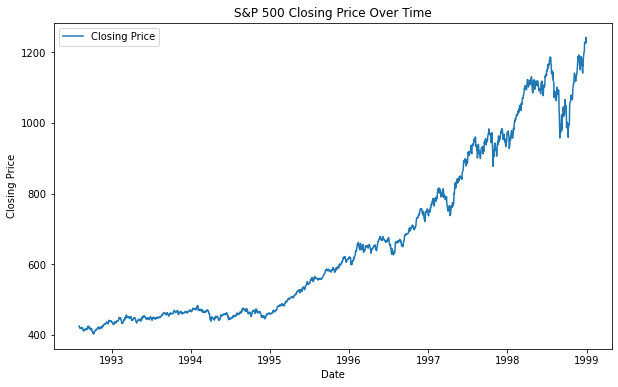

In [4]:
plt.figure(figsize=(10, 6))  
plt.plot(clean_data['Date'], clean_data['Close/Last'], label='Closing Price')  
plt.title('S&P 500 Closing Price Over Time')  
plt.xlabel('Date')  
plt.ylabel('Closing Price')  
plt.legend()  
plt.show()  

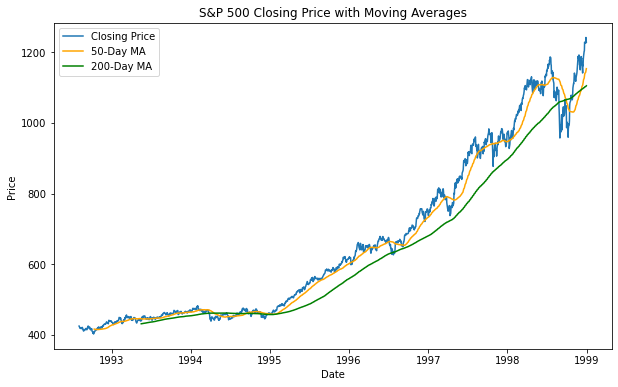

In [5]:
plt.figure(figsize=(10, 6))  
plt.plot(clean_data['Date'], clean_data['Close/Last'], label='Closing Price')  
plt.plot(clean_data['Date'], clean_data['MA50_Adj'], label='50-Day MA', color='orange')  
plt.plot(clean_data['Date'], clean_data['MA200_Adj'], label='200-Day MA', color='green')  
plt.title('S&P 500 Closing Price with Moving Averages')  
plt.xlabel('Date')  
plt.ylabel('Price')  
plt.legend()  
plt.show()  

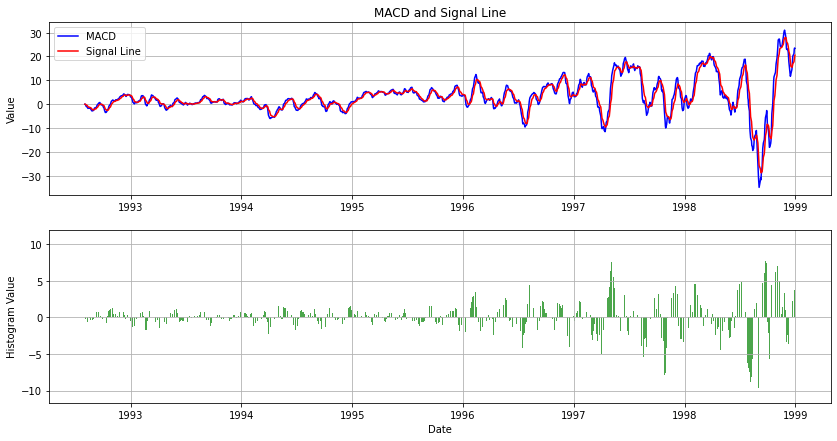

In [6]:
def plot_macd(clean_data, date_column='Date', macd_column='MACD', signal_line_column='Signal_Line', histogram_column='MACD_Histogram'):
    # Set the figure and subplot
    plt.figure(figsize=(14, 7))
    ax1 = plt.subplot(2, 1, 1)

    # Plot the MACD line and Signal line
    ax1.plot(clean_data[date_column], clean_data[macd_column], label='MACD', color='blue', linewidth=1.5)
    ax1.plot(clean_data[date_column], clean_data[signal_line_column], label='Signal Line', color='red', linewidth=1.5)

    # Adding legend to the plot
    ax1.legend(loc='upper left')

    # Plot title and labels
    ax1.set_title('MACD and Signal Line')
    ax1.set_ylabel('Value')
    ax1.grid(True)

    # Plot the MACD Histogram
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.bar(clean_data[date_column], clean_data[histogram_column], label='Histogram', color='green', alpha=0.7)

    # Improve layout
    ax2.grid(True)
    ax2.set_ylabel('Histogram Value')
    ax2.set_xlabel('Date')

    # Show the plot
    plt.show()

plot_macd(clean_data)

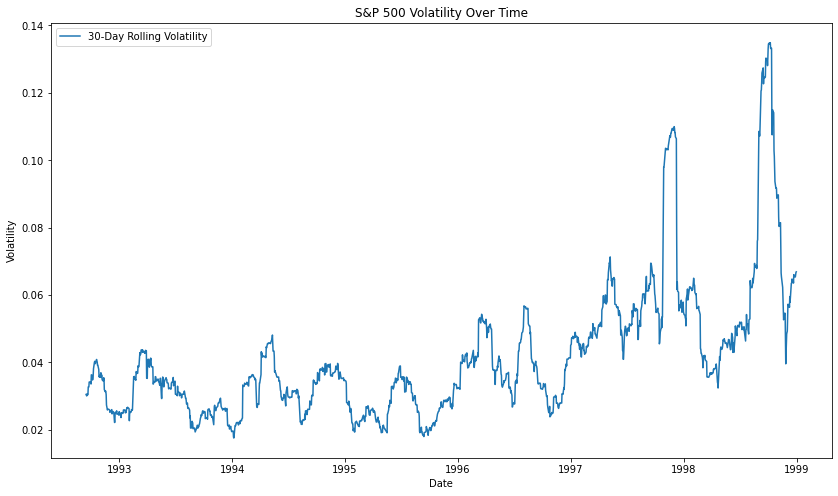

In [7]:
plt.figure(figsize=(14, 8))
plt.plot(clean_data['Date'], clean_data['Volatility'], label='30-Day Rolling Volatility')
plt.title('S&P 500 Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

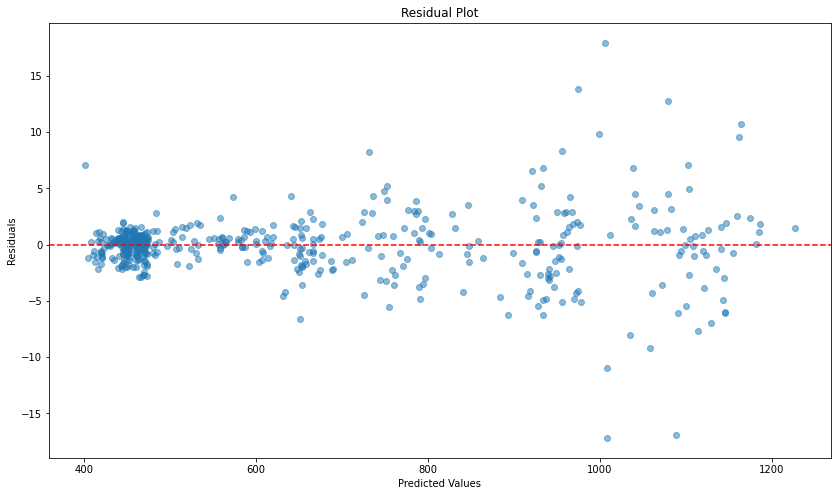

In [8]:
plt.figure(figsize=(14, 8))
plt.scatter(clean_data['predictions'], clean_data['residuals'], alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

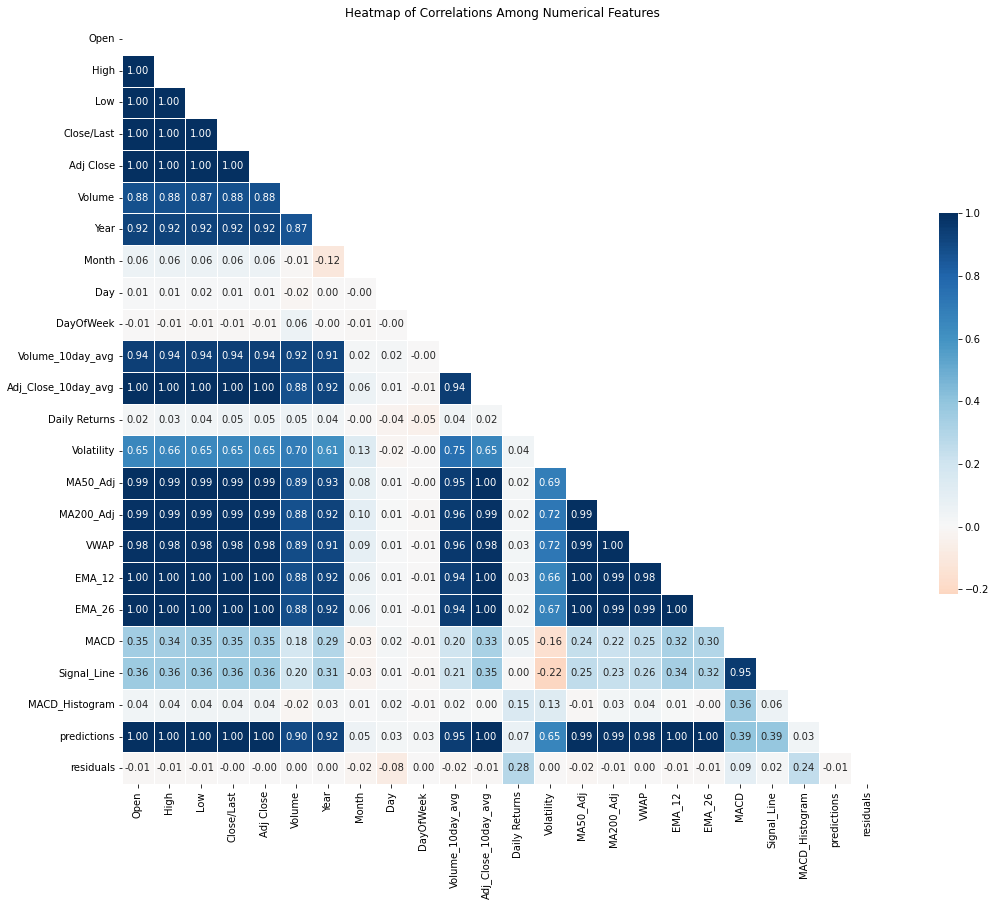

In [9]:
# Calculate the correlation matrix
corr = clean_data.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(20, 14))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot=True, cmap='RdBu', center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, fmt=".2f")

plt.title('Heatmap of Correlations Among Numerical Features')
plt.show()

NameError: name 'cv_mse_scores_abs' is not defined

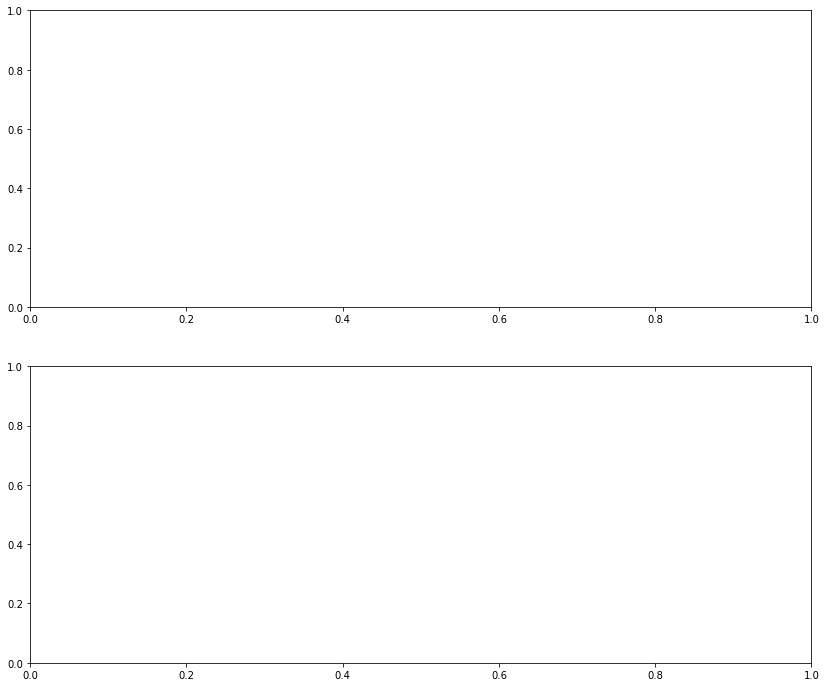

In [10]:
# Assuming cv_mse_scores_abs, data_handler.mse, data_handler.mae, data_handler.r2, and avg_cv_mse_abs are defined

# Visualization
fig, ax = plt.subplots(2, 1, figsize=(14, 12))

# Plot for Cross-Validation MSE Scores
bars1 = ax[0].bar(range(len(cv_mse_scores_abs)), cv_mse_scores_abs, color='skyblue')
ax[0].set_title('Cross-Validation MSE Scores')
ax[0].set_xlabel('Fold')
ax[0].set_ylabel('MSE')
ax[0].set_xticks(range(len(cv_mse_scores_abs)))
ax[0].set_xticklabels([f'Fold {i+1}' for i in range(len(cv_mse_scores_abs))])

# Annotating each bar with its value
for bar in bars1:
    height = bar.get_height()
    ax[0].annotate(f'{height:.2f}',
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords='offset points',
                   ha='center', va='bottom')

# Plot for Overall Metrics Comparison
metrics = ['MSE', 'MAE', 'R²', 'Avg CV MSE']
values = [data_handler.mse, data_handler.mae, data_handler.r2, avg_cv_mse_abs]
bars2 = ax[1].bar(metrics, values, color=['red', 'green', 'blue', 'orange'])
ax[1].set_title('Model Evaluation Metrics')
ax[1].set_ylabel('Value')

# Annotating each bar in the second subplot
for idx, bar in enumerate(bars2):
    height = bar.get_height()
    if metrics[idx] == 'R²':  # Check if the metric is R² to apply different formatting
        annotation_format = f'{height:.5f}'  # Five decimal places for R²
    else:
        annotation_format = f'{height:.2f}'  # Two decimal places for other metrics
    ax[1].annotate(annotation_format,
                   xy=(bar.get_x() + bar.get_width() / 2, height),
                   xytext=(0, 3),  # 3 points vertical offset
                   textcoords='offset points',
                   ha='center', va='bottom')

plt.tight_layout()
plt.show()


Total Return: -37.98%


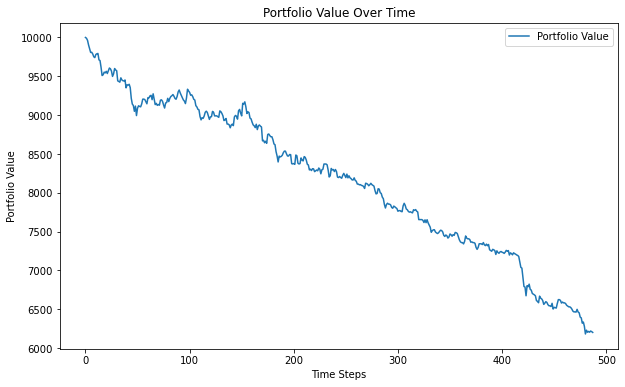

In [11]:

class BacktestSP500:
    def __init__(self, initial_capital, transaction_cost, predictions, actual_prices):
        self.initial_capital = initial_capital
        self.transaction_cost = transaction_cost
        self.predictions = predictions
        self.actual_prices = actual_prices
        # Additional initialization as needed


    def simulate_trading(self):
        self.cash = self.initial_capital  # Initialize cash based on initial capital
        self.holdings = 0  # Initialize holdings
        self.portfolio_value = [self.initial_capital]  # Initialize portfolio value list

        for prediction, actual_price in zip(self.predictions, self.actual_prices):
            if prediction > actual_price:  # Buy signal
                num_shares_to_buy = (self.cash - self.transaction_cost) // actual_price
                self.cash -= num_shares_to_buy * actual_price + self.transaction_cost
                self.holdings += num_shares_to_buy
            elif prediction < actual_price and self.holdings > 0:  # Sell signal
                self.cash += self.holdings * actual_price - self.transaction_cost
                self.holdings = 0
            self.portfolio_value.append(self.cash + self.holdings * actual_price)


    def calculate_performance_metrics(self):
        total_return = (self.portfolio_value[-1] / self.initial_capital - 1) * 100
        print(f"Total Return: {total_return:.2f}%")

    def plot_performance(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.portfolio_value, label='Portfolio Value')
        plt.title('Portfolio Value Over Time')
        plt.xlabel('Time Steps')
        plt.ylabel('Portfolio Value')
        plt.legend()
        plt.show()

# Example usage (ensure you replace `data_handler.predictions` and `data_handler.actual_prices` with actual data)
backtester = BacktestSP500(10000, 10, data_handler.predictions, data_handler.data[data_handler.ADJ_CLOSE_COLUMN])

backtester.simulate_trading()
backtester.calculate_performance_metrics()
backtester.plot_performance()